Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

calculating scores...
computing bert embedding.


  0%|          | 0/63 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/32 [00:00<?, ?it/s]

done in 3.53 seconds, 283.16 sentences/sec


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


After evaluation t5:
Allocated: 1.97 GiB, Reserved: 2.47 GiB
Generating comparative plots...


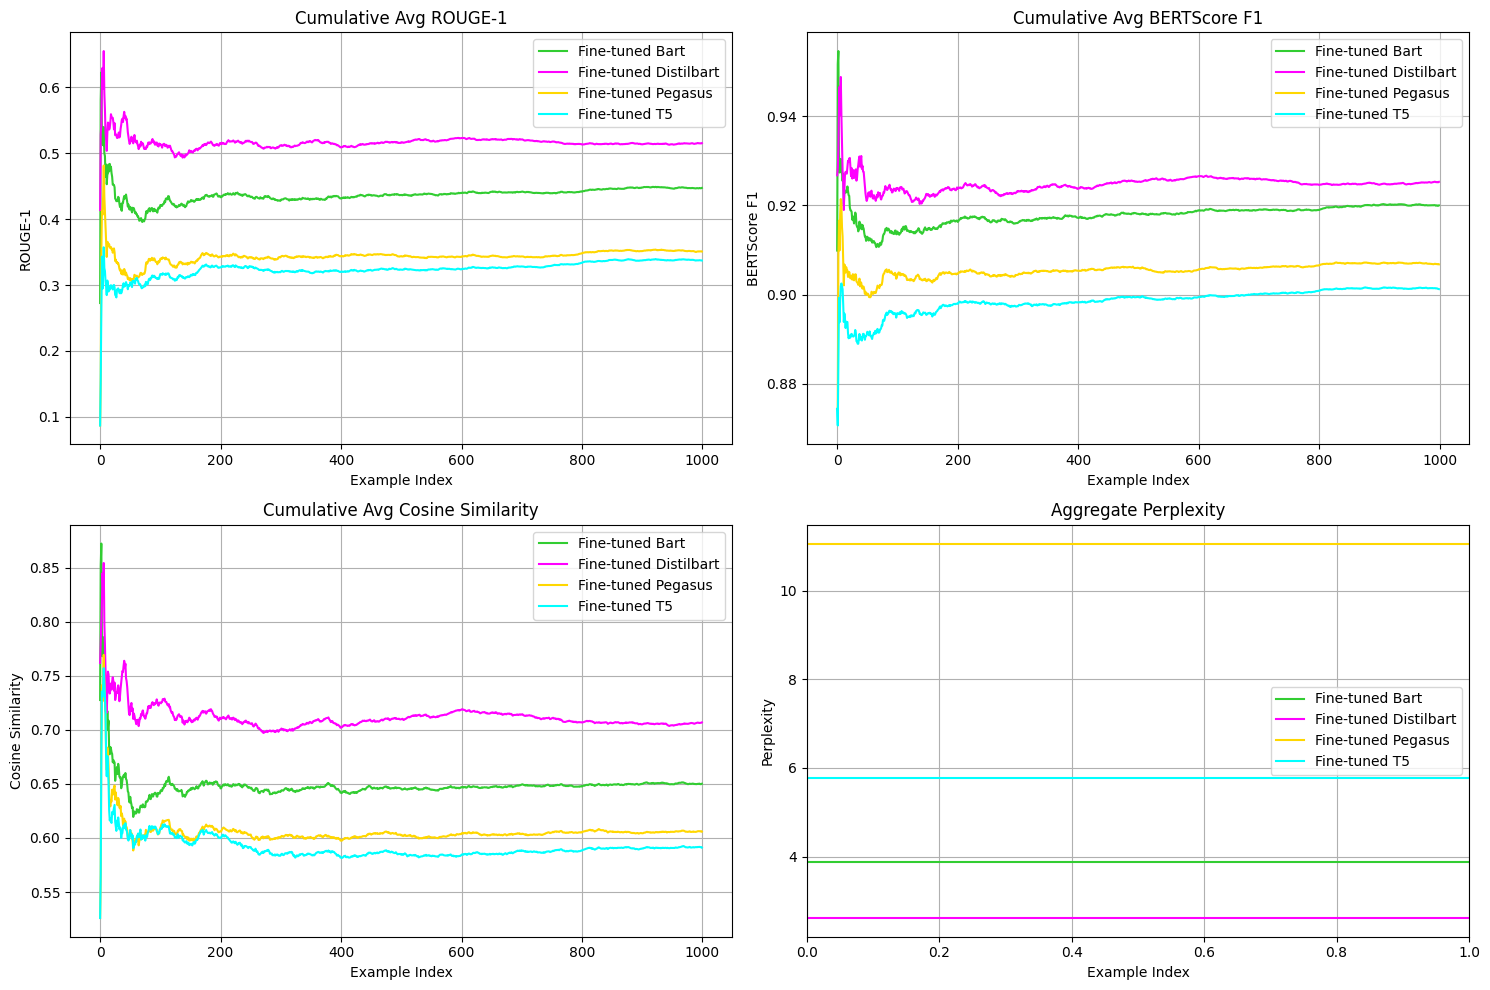

Plot saved to /content/combined_metric_curves.png
Saving evaluation results...


TypeError: Object of type float32 is not JSON serializable

In [1]:
# === Install Dependencies ===
!pip install --upgrade transformers datasets evaluate rouge_score bert_score sentence-transformers torch matplotlib -q

# === Imports ===
from datasets import Dataset
from transformers import BartTokenizer, BartForConditionalGeneration, PegasusTokenizer, PegasusForConditionalGeneration, T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer, DataCollatorForSeq2Seq, EvalPrediction
import pandas as pd
import evaluate
from bert_score import score
from sentence_transformers import SentenceTransformer, util
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import gc
import os
import warnings
import json

# === Suppress Warnings ===
warnings.filterwarnings("ignore", category=FutureWarning)

# === Set Environment Variable for Memory Management ===
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# === Clear GPU Memory Initially ===
torch.cuda.empty_cache()
gc.collect()

# === Memory Profiling ===
def print_memory():
    print(f"Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GiB, Reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GiB")

print("Initial Memory:")
print_memory()

# === Load and Preprocess Datasets ===
def load_datasets():
    # Load Abstract-Summary Dataset
    abstract_df = pd.read_csv("abstract_summaries_gptstyle.csv")[["text", "summary"]].dropna()
    abstract_df = abstract_df[abstract_df["text"].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]
    abstract_df = abstract_df[abstract_df["summary"].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]
    abstract_df = abstract_df.rename(columns={"text": "input_text", "summary": "target_text"})
    abstract_df["input_text"] = "summarize: " + abstract_df["input_text"]

    # Load Q&A Dataset
    qa_df = pd.read_csv("qanda.csv", encoding='latin-1')[["Question", "Answer"]].dropna()
    qa_df = qa_df[qa_df["Question"].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]
    qa_df = qa_df[qa_df["Answer"].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]
    qa_df = qa_df.rename(columns={"Question": "input_text", "Answer": "target_text"})
    qa_df["input_text"] = "question: " + qa_df["input_text"]

    # Combine Datasets for Training
    combined_df = pd.concat([abstract_df, qa_df], ignore_index=True)
    dataset = Dataset.from_pandas(combined_df)
    dataset = dataset.train_test_split(test_size=0.2, seed=42)
    train_dataset = dataset["train"]
    test_dataset = dataset["test"]

    # Clean Up
    del abstract_df, combined_df, dataset
    gc.collect()
    torch.cuda.empty_cache()
    return train_dataset, test_dataset, qa_df

print("Loading datasets...")
train_dataset, test_dataset, qa_df = load_datasets()
print("After data loading:")
print_memory()

# === Load 1000 Q&A Pairs for Evaluation ===
def load_eval_dataset(qa_df, num_samples=1000):
    qa_df = qa_df[qa_df["input_text"].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]
    qa_df = qa_df[qa_df["target_text"].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]
    if len(qa_df) < num_samples:
        print(f"Warning: Only {len(qa_df)} Q&A pairs available, using all.")
        eval_df = qa_df.sample(n=len(qa_df), random_state=42).reset_index(drop=True)
    else:
        eval_df = qa_df.sample(n=num_samples, random_state=42).reset_index(drop=True)
    eval_dataset = Dataset.from_pandas(eval_df)
    return eval_dataset

print("Loading 1000 Q&A pairs for evaluation...")
eval_dataset = load_eval_dataset(qa_df)
print(f"Selected {len(eval_dataset)} Q&A pairs for evaluation.")
print("After eval dataset loading:")
print_memory()

# === Model Configurations ===
model_configs = {
    "bart": {
        "name": "facebook/bart-base",
        "tokenizer_class": BartTokenizer,
        "model_class": BartForConditionalGeneration,
        "output_dir": "./bart-multitask-finetuned",
        "color": "limegreen"
    },
    "distilbart": {
        "name": "sshleifer/distilbart-cnn-6-6",
        "tokenizer_class": BartTokenizer,
        "model_class": BartForConditionalGeneration,
        "output_dir": "./distilbart-multitask-finetuned",
        "color": "magenta"
    },
    "pegasus": {
        "name": "google/pegasus-xsum",
        "tokenizer_class": PegasusTokenizer,
        "model_class": PegasusForConditionalGeneration,
        "output_dir": "./pegasus-multitask-finetuned",
        "color": "gold"
    },
    "t5": {
        "name": "t5-small",
        "tokenizer_class": T5Tokenizer,
        "model_class": T5ForConditionalGeneration,
        "output_dir": "./t5-multitask-finetuned",
        "color": "cyan"
    }
}

# === Preprocess Function ===
def preprocess_function(examples, tokenizer, max_input_length=128, max_target_length=32, is_t5=False):
    inputs = [str(text) for text in examples["input_text"] if text and isinstance(text, str)]
    targets = [str(text) for text in examples["target_text"] if text and isinstance(text, str)]
    model_inputs = tokenizer(
        inputs,
        truncation=True,
        padding="max_length",
        max_length=max_input_length,
        return_tensors="pt"
    )
    labels = tokenizer(
        targets,
        truncation=True,
        padding="max_length",
        max_length=max_target_length,
        return_tensors="pt"
    )["input_ids"]

    if not is_t5:
        # For BART and PEGASUS, replace padding token id with -100
        labels = [[(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels]
    model_inputs["labels"] = labels
    return {
        "input_ids": model_inputs["input_ids"].tolist(),
        "attention_mask": model_inputs["attention_mask"].tolist(),
        "labels": model_inputs["labels"]
    }

# === Custom Trainer ===
class CustomTrainer(Trainer):
    def predict(self, test_dataset, ignore_keys=None):
        self.model.eval()
        data_loader = self.get_eval_dataloader(test_dataset)
        predictions = []
        labels = []
        max_length = 32

        for batch in data_loader:
            input_ids = batch['input_ids'].to(self.model.device)
            attention_mask = batch['attention_mask'].to(self.model.device)
            batch_labels = batch['labels'].to(self.model.device)
            with torch.no_grad():
                outputs = self.model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_length=max_length,
                    num_beams=4,
                    early_stopping=True
                )
            padded_outputs = torch.nn.functional.pad(
                outputs,
                (0, max_length - outputs.size(1)),
                value=self.tokenizer.pad_token_id
            )
            predictions.extend(padded_outputs.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())
            del input_ids, attention_mask, batch_labels, outputs, padded_outputs
            torch.cuda.empty_cache()
            gc.collect()

        predictions = np.array(predictions)
        labels = np.array(labels)
        metrics = self.compute_metrics(EvalPrediction(predictions=predictions, label_ids=labels))
        return predictions, labels, metrics

# === Compute Metrics ===
def compute_rouge_metrics(eval_pred, tokenizer):
    preds, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    rouge = evaluate.load("rouge")
    return rouge.compute(predictions=decoded_preds, references=decoded_labels)

# === Train and Evaluate Model ===
def train_and_evaluate(model_name, config, train_dataset, eval_dataset):
    print(f"\n=== Processing {model_name} ===")
    tokenizer = config["tokenizer_class"].from_pretrained(config["name"])
    model = config["model_class"].from_pretrained(config["name"]).to('cuda')
    model.gradient_checkpointing_enable()

    # Preprocess datasets
    is_t5 = model_name == "t5"
    train_ds = train_dataset.map(
        lambda x: preprocess_function(x, tokenizer, is_t5=is_t5),
        batched=True,
        remove_columns=["input_text", "target_text"]
    )
    eval_ds = eval_dataset.map(
        lambda x: preprocess_function(x, tokenizer, is_t5=is_t5),
        batched=True,
        remove_columns=["input_text", "target_text"]
    )
    train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    eval_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

    # Training Arguments
    training_args = TrainingArguments(
        output_dir=config["output_dir"],
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=2,
        num_train_epochs=5,
        learning_rate=5e-5,
        weight_decay=0.01,
        eval_strategy="no",
        save_strategy="epoch",
        logging_dir="./logs",
        logging_steps=10,
        report_to="none",
        fp16=True,
        gradient_checkpointing=True
    )

    data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")

    # Trainer
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=eval_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=lambda x: compute_rouge_metrics(x, tokenizer)
    )

    # Train
    print(f"Training {model_name}...")
    trainer.train()
    model.save_pretrained(config["output_dir"])
    tokenizer.save_pretrained(config["output_dir"])
    print(f"After training {model_name}:")
    print_memory()

    # Evaluate
    print(f"Evaluating {model_name}...")
    predictions, labels, metrics = trainer.predict(eval_ds)
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(np.where(labels != -100, labels, tokenizer.pad_token_id), skip_special_tokens=True)

    # Per-Example Metrics
    rouge = evaluate.load("rouge")
    rouge1_scores = [rouge.compute(predictions=[pred], references=[ref])['rouge1'] for pred, ref in zip(decoded_preds, decoded_labels)]
    P, R, F1 = score(decoded_preds, decoded_labels, lang="en", model_type="roberta-base", batch_size=32, verbose=True)
    F1 = F1.numpy()
    embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
    pred_embeddings = embedding_model.encode(decoded_preds, convert_to_tensor=True, batch_size=32)
    label_embeddings = embedding_model.encode(decoded_labels, convert_to_tensor=True, batch_size=32)
    cos_sim = util.cos_sim(pred_embeddings, label_embeddings).diag().cpu().numpy()
    ppl = calculate_perplexity(model, eval_ds)

    # Clean Up
    del model, tokenizer, trainer, train_ds, eval_ds
    torch.cuda.empty_cache()
    gc.collect()
    print(f"After evaluation {model_name}:")
    print_memory()

    return {
        "rouge1": rouge1_scores,
        "bertscore_f1": F1,
        "cosine_sim": cos_sim,
        "perplexity": ppl,
        "decoded_preds": decoded_preds,
        "decoded_labels": decoded_labels,
        "metrics": metrics
    }

# === Perplexity Calculation ===
def calculate_perplexity(model, dataset):
    model.eval()
    losses = []
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=2)
    for batch in data_loader:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            losses.append(outputs.loss.item())
        del input_ids, attention_mask, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    return math.exp(sum(losses) / len(losses))

# === Run All Models ===
results = {}
for model_name, config in model_configs.items():
    results[model_name] = train_and_evaluate(model_name, config, train_dataset, eval_dataset)

# === Compute Cumulative Averages ===
def cumulative_avg(data):
    return np.cumsum(data) / np.arange(1, len(data) + 1)

# === Plot Comparative Graphs ===
print("Generating comparative plots...")
plt.figure(figsize=(15, 10))

# ROUGE-1
plt.subplot(2, 2, 1)
for model_name, config in model_configs.items():
    cum_rouge1 = cumulative_avg(results[model_name]["rouge1"])
    plt.plot(cum_rouge1, label=f"Fine-tuned {model_name.capitalize()}", color=config["color"])
plt.title('Cumulative Avg ROUGE-1')
plt.xlabel('Example Index')
plt.ylabel('ROUGE-1')
plt.legend()
plt.grid(True)

# BERTScore F1
plt.subplot(2, 2, 2)
for model_name, config in model_configs.items():
    cum_f1 = cumulative_avg(results[model_name]["bertscore_f1"])
    plt.plot(cum_f1, label=f"Fine-tuned {model_name.capitalize()}", color=config["color"])
plt.title('Cumulative Avg BERTScore F1')
plt.xlabel('Example Index')
plt.ylabel('BERTScore F1')
plt.legend()
plt.grid(True)

# Cosine Similarity
plt.subplot(2, 2, 3)
for model_name, config in model_configs.items():
    cum_cos = cumulative_avg(results[model_name]["cosine_sim"])
    plt.plot(cum_cos, label=f"Fine-tuned {model_name.capitalize()}", color=config["color"])
plt.title('Cumulative Avg Cosine Similarity')
plt.xlabel('Example Index')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.grid(True)

# Perplexity
plt.subplot(2, 2, 4)
for model_name, config in model_configs.items():
    ppl = results[model_name]["perplexity"]
    plt.axhline(y=ppl, label=f"Fine-tuned {model_name.capitalize()}", color=config["color"])
plt.title('Aggregate Perplexity')
plt.xlabel('Example Index')
plt.ylabel('Perplexity')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/content/combined_metric_curves.png')
plt.show()
print("Plot saved to /content/combined_metric_curves.png")

# === Save Evaluation Results ===
print("Saving evaluation results...")
combined_results = {}
for model_name in model_configs:
    combined_results[model_name] = {
        "rouge_finetuned": results[model_name]["metrics"],
        "bertscore_finetuned": {
            "F1": np.mean(results[model_name]["bertscore_f1"])
        },
        "cosine_sim_finetuned": np.mean(results[model_name]["cosine_sim"]),
        "perplexity_finetuned": results[model_name]["perplexity"]
    }

with open("/content/combined_evaluation_results.json", "w") as f:
    json.dump(combined_results, f, indent=4)
print("Results saved to /content/combined_evaluation_results.json")

# === Final Memory Check ===
torch.cuda.empty_cache()
gc.collect()
print("Final Memory:")
print_memory()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')